In [1]:
!pip install torch
!pip install matplotlib
!pip install torchvision
!pip install cv

In [2]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision 
import torchvision.transforms as T 
from PIL import Image
import random
import cv
#img_dir = "C:/Users/Adam/Downloads/UF_Spring_2022/Deep_Learning/Proj2/face_images/"
#img_dir = "/Users/sahajpatel/Downloads/face_images/"
img_dir = "Deep Learning Data/face_images"
torch.set_default_tensor_type('torch.FloatTensor')

In [3]:
def load_images_from_folder(folder, num):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            #ret = cv2.imwrite('Faces/Augmented/%05d.jpg' % (num), img)
            num += 1
    return images

In [4]:
k = 0
data = load_images_from_folder(img_dir, k)

In [5]:
data = np.asarray(data)
print(data.shape)

(750, 128, 128, 3)


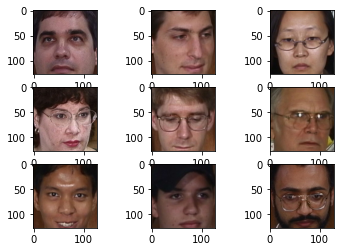

In [6]:
for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[i][:,:,:])

Now we will convert how the images are stored and augment them to get more data 

In [7]:
data = torch.from_numpy(data) #converts numpy matrix to tensor
data = torch.movedim(data, 3, 1) #moves the rgb to the second index
data = data[torch.randperm(data.size()[0])]#randomly shuffles tensor along first dim 

In [8]:
#helper function to print pytorch tensor 
#input is a single tensor
def print_tensor_to_numpy(tensor):
    tensor_reshape = torch.movedim(tensor, 0, 2)
    npimg = tensor_reshape.numpy()
    plt.imshow(npimg[:, :, :])   

Augment Dataset

In [9]:
#flips the image, takes a single image and shows result if show is set to True
def flip_img(tensor, show =False):
    flipped_img = torch.flip(tensor, (2,))
    if show == True:
        print_tensor_to_numpy(flipped_img)
    return flipped_img

In [10]:
#crops image takes a single image tensor and crops it, shows image if show is set to true
def crop_img(tensor, show = False):
    crop = T.RandomCrop((96,96)) # transform for square crop
    resize_crop = T.Resize((128,128)) #resizes image back to original dimension
    cropped_img = resize_crop(crop(tensor)) 
    if show == True:
        print_tensor_to_numpy(cropped_img)
    return cropped_img

In [11]:
def tint_img(tensor, show = False):
    tint_val = 0.1*random.randrange(6, 10)
    tensor[0, :, :] = tint_val*tensor[0, :, :]
    tensor[1, :, :] = tint_val*tensor[1, :, :]
    tensor[2, :, :] = tint_val*tensor[2, :, :]
    tinted_img = tensor[:, :, :]
    if show == True:
        print_tensor_to_numpy(tinted_img)
    return tinted_img

In [12]:
########################

#its not really specified how the new data should be made for example should we flip all of the images, 750+750
#and then crop the original images 3 times an image to make another 3*750 images
#and then tint the original images 0.6-1 thus producing 4*750
#or if we should just apply some random combination of all of the transforms and use that to create the new images


######################
#weird combination of all the transforms
def create_new_img(tensor, show = False):
    chance = random.randrange(0, 10)
    #60% chance of only one transformation
    if (chance < 2):
        new_img = flip_img(tensor) 
    elif (chance >= 2 and chance <4):
        new_img = crop_img(tensor)
    elif (chance >= 4 and chance <6):
        new_img = tint_img(tensor)
    #40% chance of more complex transformations
    elif (chance >= 6 and chance <8):
        tensor_cropped = crop_img(tensor)
        tensor_tinted = tint_img(tensor_cropped)
        new_img = tensor_tinted
    elif (chance >= 8 and chance <=10):
        tensor_flipped = flip_img(tensor) 
        tensor_cropped = crop_img(tensor_flipped)
        tensor_tinted = tint_img(tensor_cropped)
        new_img = tensor_tinted
        
    if show == True:
        print_tensor_to_numpy(new_img)
        
    return new_img


In [13]:
###for loop which appends the newly created images (takes a while)
k = 750
for j in range(0, 1): #change this 1 to 7
    for i in range(0, 750):
        new_img = create_new_img(data[i, :, :, :])
        new_img = new_img[None, :, :, :] #extending the dimensions so that vector can be appended
        data = torch.cat((data, new_img), 0)
        tmp = new_img.numpy()
        tmp = tmp[0].swapaxes(0,1)
        tmp = tmp.swapaxes(1,2)
        #plt.imshow(tmp)
        #ret = cv2.imwrite('Faces/Augmented/%05d_A.jpg' % (k), tmp)
        k += 1
print("Done augmenting data...")

Done augmenting data...


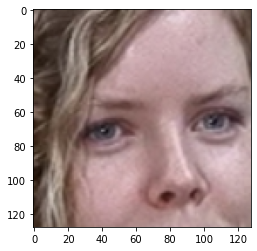

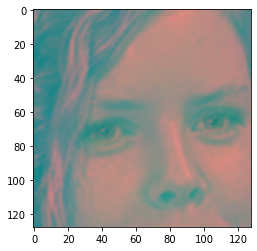

In [14]:
image = np.asarray(data[1350, :,:,:])
image = np.swapaxes(image, 1, 0)
image = np.swapaxes(image, 1, 2)
plt.figure()
plt.imshow(image)
#image = cv.fromarray(image)
imageLAB = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
plt.figure()
plt.imshow(imageLAB)
l,a,b = cv2.split(imageLAB)

In [15]:
def convToLab_saveToFile(dataset):
    for i in range(len(dataset)):
        image = np.asarray(dataset[i,:,:,:])
        image = np.swapaxes(image,1,0)
        image = np.swapaxes(image,1,2)
        imageLAB = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l,a,b = cv2.split(imageLAB)
        statusL = cv2.imwrite('Faces/L/%05d_L.jpg' % (i), l)
        statusa = cv2.imwrite('Faces/a/%05d_a.jpg' % (i), a)
        statusb = cv2.imwrite('Faces/b/%05d_b.jpg' % (i), b)
#convToLab_saveToFile(data)
print("Done converting")

Done converting


In [2]:
print("HERE")
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        self.conv6 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        self.conv7 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.conv7(x)
        x = F.relu(x)
        return x

print(data[0,0])
normData = data[:,0,:,:]/100
print(normData[0,0])
model = NN()
print(model)
rand = torch.rand((1,3,128,128))
print(model(rand))

HERE


NameError: name 'nn' is not defined

In [3]:
print("LAST")

LAST
